In [15]:
import os
import glob
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Plotting style
sns.set_theme(style='whitegrid')

# ===========================
# Load and clean the data
# ===========================
base_dir = "analysis/abide"
selected_rois = ['Temporal Region',
                 'Prefrontal Cortex',
                 'Cingulate Cortex',
                 'Amygdala',
                 'Hippocampus',
                 'Insula',
                 'Cerebellum']


def load_and_filter_data(files, group_name, selected_rois=None):
    df_list = []
    for file in files:
        df = pd.read_csv(file)
        df['source_file'] = file
        df['group'] = group_name
        if selected_rois is not None:
            df = df[df['Region'].isin(selected_rois)]
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)


asd_files = glob.glob(os.path.join(base_dir, "*", "patient", "metrics", "abide_roi_metrics.csv"))
asd_data = load_and_filter_data(asd_files, 'ASD', selected_rois)

control_files = glob.glob(os.path.join(base_dir, "*", "control", "metrics", "abide_roi_metrics.csv"))
control_data = load_and_filter_data(control_files, 'Control', selected_rois)

all_data = pd.concat([asd_data, control_data], ignore_index=True)
all_data.dropna(inplace=True)


# Extract age bin from file path
def extract_age_bin(path):
    match = re.search(r"abide[\\/](.*?)[\\/]", path)
    return match.group(1) if match else "unknown"


all_data['age_bin'] = all_data['source_file'].apply(extract_age_bin)
age_bin_order = ["11-", "12_17", "18_25", "25+"]
all_data['age_bin'] = pd.Categorical(all_data['age_bin'], categories=age_bin_order, ordered=True)


# Pivot data by subject
def create_pivot(df):
    subject_ages = df.groupby('SubjectID')['Age'].first()
    subject_bins = df.groupby('SubjectID')['age_bin'].first()
    pivot_df = df.pivot_table(index='SubjectID', columns='Region', values=['Closeness', 'Clustering', 'Degree'])
    pivot_df.columns = [f'{metric}_{roi}' for metric, roi in pivot_df.columns]
    pivot_df.reset_index(inplace=True)
    pivot_df['Age'] = pivot_df['SubjectID'].map(subject_ages)
    pivot_df['age_bin'] = pivot_df['SubjectID'].map(subject_bins)
    return pivot_df


asd_pivot_df = create_pivot(all_data[all_data['group'] == 'ASD']).dropna()
asd_pivot_df['group'] = 'ASD'

control_pivot_df = create_pivot(all_data[all_data['group'] == 'Control']).dropna()
control_pivot_df['group'] = 'Control'

In [16]:
# ===========================
# HMM for ASD patients
# ===========================
roi_columns_asd = [col for col in asd_pivot_df.columns if any(m in col for m in ['Closeness', 'Clustering', 'Degree'])]
X_asd = asd_pivot_df[roi_columns_asd].values

# Remove zero-variance features
variances = X_asd.var(axis=0)
X_asd = X_asd[:, variances > 0]
roi_columns_asd = [col for i, col in enumerate(roi_columns_asd) if variances[i] > 0]

# Scale data
scaler_asd = StandardScaler()
X_asd_scaled = scaler_asd.fit_transform(X_asd)

# Fit HMM with multiple seeds and keep the best
best_model_asd = None
best_score = -np.inf
n_states = 2

for seed in range(10):
    try:
        model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=400, random_state=seed)
        model.fit(X_asd_scaled)
        score = model.score(X_asd_scaled)
        if not np.isnan(score) and score > best_score:
            best_model_asd = model
            best_score = score
    except Exception as e:
        print(f"HMM error for seed {seed}: {e}")

if best_model_asd is not None:
    hidden_states_asd = best_model_asd.predict(X_asd_scaled)
    asd_pivot_df['ASD_severity_state'] = hidden_states_asd
else:
    print("No valid HMM model found for ASD patients.")

In [17]:
# ===========================
# Simulate pseudo-longitudinal trajectories (bootstrapping)
# ===========================
from collections import Counter

N_BOOTSTRAPS = 200
age_bins = age_bin_order
state_trajectories = []

for b in range(N_BOOTSTRAPS):
    trajectory = []
    valid = True
    for bin_label in age_bins:
        candidates = asd_pivot_df[asd_pivot_df['age_bin'] == bin_label]
        if candidates.empty:
            valid = False
            break
        chosen = candidates.sample(n=1, random_state=b)
        features = chosen[roi_columns_asd].values
        features_scaled = scaler_asd.transform(features)
        state = best_model_asd.predict(features_scaled)[0]
        trajectory.append(state)
    if valid:
        state_trajectories.append(tuple(trajectory))

In [18]:
# ===========================
# Show most frequent trajectories
# ===========================
trajectory_counts = Counter(state_trajectories)
most_common = trajectory_counts.most_common(5)

print("\nMost frequent state trajectories:")
for i, (traj, count) in enumerate(most_common):
    print(f"{i + 1}. {traj} (frequency: {count})")


Most frequent state trajectories:
1. (0, 0, 0, 0) (frequency: 163)
2. (0, 1, 0, 0) (frequency: 14)
3. (0, 0, 1, 0) (frequency: 12)
4. (1, 0, 0, 0) (frequency: 8)
5. (0, 0, 0, 1) (frequency: 1)


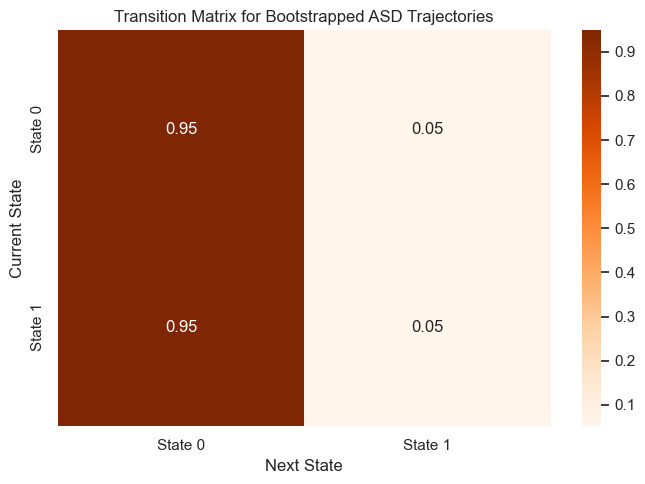

In [19]:
# ===========================
# Transition matrix
# ===========================
transition_counts = np.zeros((n_states, n_states), dtype=int)

for traj in state_trajectories:
    for (s1, s2) in zip(traj[:-1], traj[1:]):
        transition_counts[s1, s2] += 1

transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)

# Visualize transition matrix
plt.figure(figsize=(7, 5))
sns.heatmap(transition_probs, annot=True, fmt=".2f", cmap='Oranges',
            xticklabels=[f'State {i}' for i in range(n_states)],
            yticklabels=[f'State {i}' for i in range(n_states)])
plt.title("Transition Matrix for Bootstrapped ASD Trajectories")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.tight_layout()
plt.show()

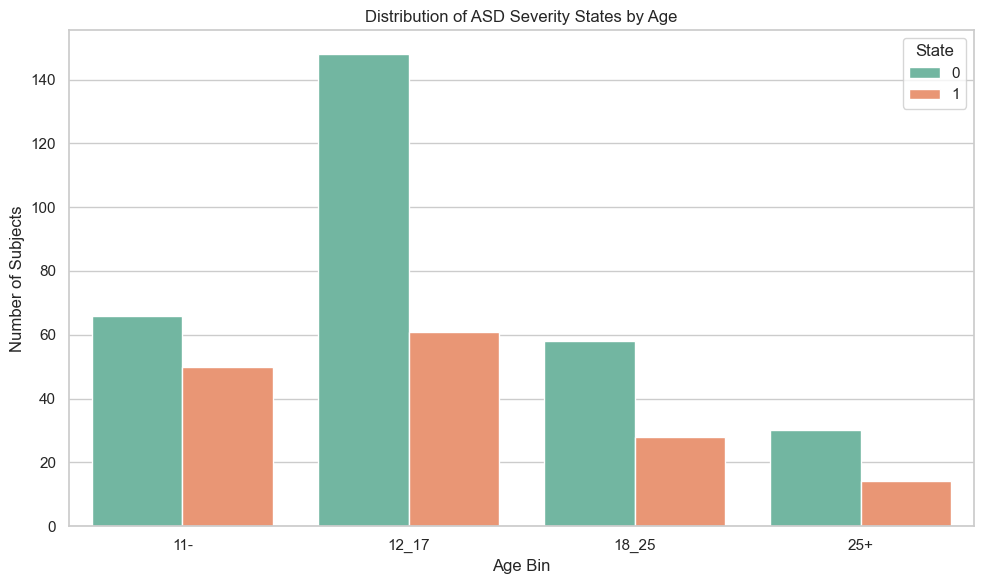

In [20]:
# ===========================
# Visualize HMM state distribution across age bins
# ===========================
plt.figure(figsize=(10, 6))
sns.countplot(data=asd_pivot_df, x='age_bin', hue='ASD_severity_state', palette='Set2')
plt.title('Distribution of ASD Severity States by Age')
plt.xlabel('Age Bin')
plt.ylabel('Number of Subjects')
plt.legend(title='State')
plt.tight_layout()
plt.show()